<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#библиотеки" data-toc-modified-id="библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>библиотеки</a></span></li><li><span><a href="#переменные" data-toc-modified-id="переменные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>переменные</a></span></li><li><span><a href="#предобработка-фото" data-toc-modified-id="предобработка-фото-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>предобработка фото</a></span></li><li><span><a href="#создать-вручную-аннотации---полигоны/круги" data-toc-modified-id="создать-вручную-аннотации---полигоны/круги-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>создать вручную аннотации - полигоны/круги</a></span></li><li><span><a href="#загрузка-фото-и-списка" data-toc-modified-id="загрузка-фото-и-списка-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>загрузка фото и списка</a></span></li><li><span><a href="#выборки" data-toc-modified-id="выборки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>выборки</a></span></li><li><span><a href="#обучение" data-toc-modified-id="обучение-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>обучение</a></span></li><li><span><a href="#предсказание" data-toc-modified-id="предсказание-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>предсказание</a></span></li><li><span><a href="#тестовый-прогон" data-toc-modified-id="тестовый-прогон-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>тестовый прогон</a></span></li></ul></div>

## библиотеки

In [1]:
# !pip install opencv-python
# !pip install segmentation_models

import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps, ImageEnhance
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

from keras_unet_collection import models
from tensorflow.keras import backend as K

# from tensorflow.keras import models
import keras.backend as K

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.ndimage import center_of_mass

from tensorflow.keras.models import load_model

# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.optimizers import RMSprop
# import matplotlib.pyplot as plt

import numpy as np
import cv2
import os
import pandas as pd
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

# import os
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

## переменные

In [2]:
# Переменные
epochs=185
random_state=1234567
test_size=0.05 
batch_size=4

l_max = [64, 128, 256, 512, 1024]
l_med = [32, 64, 128, 256, 512]
l_min = [16, 32, 64, 128, 256]
layers = l_min

# Целевое разрешение
target_width, target_height = 699, 699


# new_width, new_height = 512, 512 # Разрешение для изменения размера
# suare_side_pix = 224 # итоговое изображение для проставления точек измерения
# csv_file =       r"E:\gnat\gnat_set_center\gnat_set_center_512.csv"  # Путь к файлу CSV

new_width, new_height = 256, 256 # Разрешение для изменения размера
suare_side_pix = 120 # итоговое изображение для проставления точек измерения
csv_file =       r"E:\gnat\gnat_set_center\gnat_set_center_256.csv"  # Путь к файлу CSV


# Путь к директории с фотографиями
foto_directory = r"E:\gnat\gnat_set_center"



# время обучения
# 200эпох // l_min = [16, 32, 64, 128, 256] // new_width, new_height = 256, 256 // 16мин
# 200эпох // l_min = [16, 32, 64, 128, 256] // new_width, new_height = 512, 512 //Wall time: 1h 21min 53s
# 

## предобработка фото

In [3]:
# # ОБРЕЗКА+ИНВЕРТИРОВАНИЕ+КОНТРАСТ

# Перебор всех файлов в директории
for filename in os.listdir(foto_directory):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Проверка, что файл является изображением
        img_path = os.path.join(foto_directory, filename)
        with Image.open(img_path) as img:
            # Проверка, нужно ли обрезать изображение
            if img.size[0] > target_width or img.size[1] > target_height:
                # Обрезка по горизонтали
                total_crop_width = img.size[0] - target_width
                left_crop = total_crop_width * 0.80
                right_crop = total_crop_width * 0.20
                left = left_crop
                right = img.size[0] - right_crop

                # Обрезка по вертикали
                total_crop_height = img.size[1] - target_height
                top_crop = total_crop_height * 0.5
                bottom_crop = total_crop_height * 0.5
                top = top_crop
                bottom = img.size[1] - bottom_crop

                # Обрезка изображения
                img = img.crop((left, top, right, bottom))

                           
            # БЕЗ ОБРАБОТКИ    
            # 1 Инвертирование цветов
            img_inverted = img
            # 2 Увеличение контрастности
            enhancer = ImageEnhance.Contrast(img_inverted)           
            img_contrasted = enhancer.enhance(1.0)  # Увеличиваем контраст на %            
                      
#             # ОБРАБОТАТЬ
#             img_inverted = ImageOps.invert(img)
#             enhancer = ImageEnhance.Contrast(img_inverted)
#             img_contrasted = enhancer.enhance(2.0)  # Увеличиваем контраст на %
            
                       
            # 3 Изменение размера до new_width x new_height
            img_resized = img_contrasted.resize((new_width, new_height))
            
            # Сохранение обработанного изображения, заменяя оригинал
            img_resized.save(img_path)

## создать вручную аннотации - полигоны/круги

In [4]:
# stop

In [5]:
# # маски (МНОГОУГОЛЬНИКА)

# # Сортировка списка файлов
# file_list = sorted([file for file in os.listdir(foto_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])

# # Загрузка изображений с сортировкой
# def load_images(directory, file_list):
#     images = []
#     for file in file_list:
#         img_path = os.path.join(directory, file)
#         img = load_img(img_path, color_mode='rgb')
#         img = img_to_array(img)
#         images.append(img)
#     return np.array(images)

# # Чтение данных из CSV
# df = pd.read_csv(csv_file)

# # Создание масок с сортировкой
# masks = []
# for file in file_list:
#     row = df[df['filename'] == file].iloc[0]
#     region = json.loads(row['region_shape_attributes'])
#     x_coords = region['all_points_x']
#     y_coords = region['all_points_y']
#     coords = list(zip(x_coords, y_coords))

#     # Для создания маски, мы предполагаем, что все изображения имеют одинаковый размер
#     # который является целевым разрешением (? , ?)
#     mask = np.zeros((new_height, new_width), dtype=np.uint8)
#     cv2.fillPoly(mask, [np.array(coords)], color=1)
#     masks.append(mask)

# # Конвертировать список масок в массив numpy
# masks = np.array(masks)

# # Теперь `images` и `masks` загружены в соответствии с сортированным списком файлов
# images = load_images(foto_directory, file_list)

# # Нормализация изображений
# images = images.astype('float32') / 255
# masks = masks.astype('float32')



## загрузка фото и списка

In [6]:
# маски (КРУГА)

# Сортировка списка файлов
file_list = sorted([file for file in os.listdir(foto_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Загрузка изображений с сортировкой
def load_images(directory, file_list):
    images = []
    for file in file_list:
        img_path = os.path.join(directory, file)
        img = load_img(img_path, color_mode='rgb')
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

# Чтение данных из CSV
df = pd.read_csv(csv_file)

# Создание масок для кругов с сортировкой
masks = []
for file in file_list:
    row = df[df['filename'] == file].iloc[0]
    region = json.loads(row['region_shape_attributes'])
    
    # Убедимся, что значения координат и радиуса являются целыми числами
    cx = int(region['cx'])
    cy = int(region['cy'])
    r = int(region['r'])

    # Создание маски для круга
    mask = np.zeros((new_height, new_width), dtype=np.uint8)
    cv2.circle(mask, (cx, cy), r, color=1, thickness=-1)
    masks.append(mask)

# Конвертировать список масок в массив numpy
masks = np.array(masks)

# Теперь `images` и `masks` загружены в соответствии с сортированным списком файлов
images = load_images(foto_directory, file_list)

# Нормализация изображений
images = images.astype('float32') / 255
masks = masks.astype('float32')


# -------------------
# Создание инвертированных масок для кругов с сортировкой (с черным кругом на суставе)
inverted_masks = []
for mask in masks:
    # Инвертирование маски
    inverted_mask = 1 - mask
    inverted_masks.append(inverted_mask)

# Конвертировать список инвертированных масок в массив numpy
inverted_masks = np.array(inverted_masks)

# Теперь есть `images` и инвертированные `masks` в соответствии с сортированным списком файлов
# Нормализация инвертированных масок, 
inverted_masks = inverted_masks.astype('float32')
masks = inverted_masks


## выборки

In [7]:
# Разделение данных на обучающую и тестовую выборки
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=test_size, random_state=random_state)

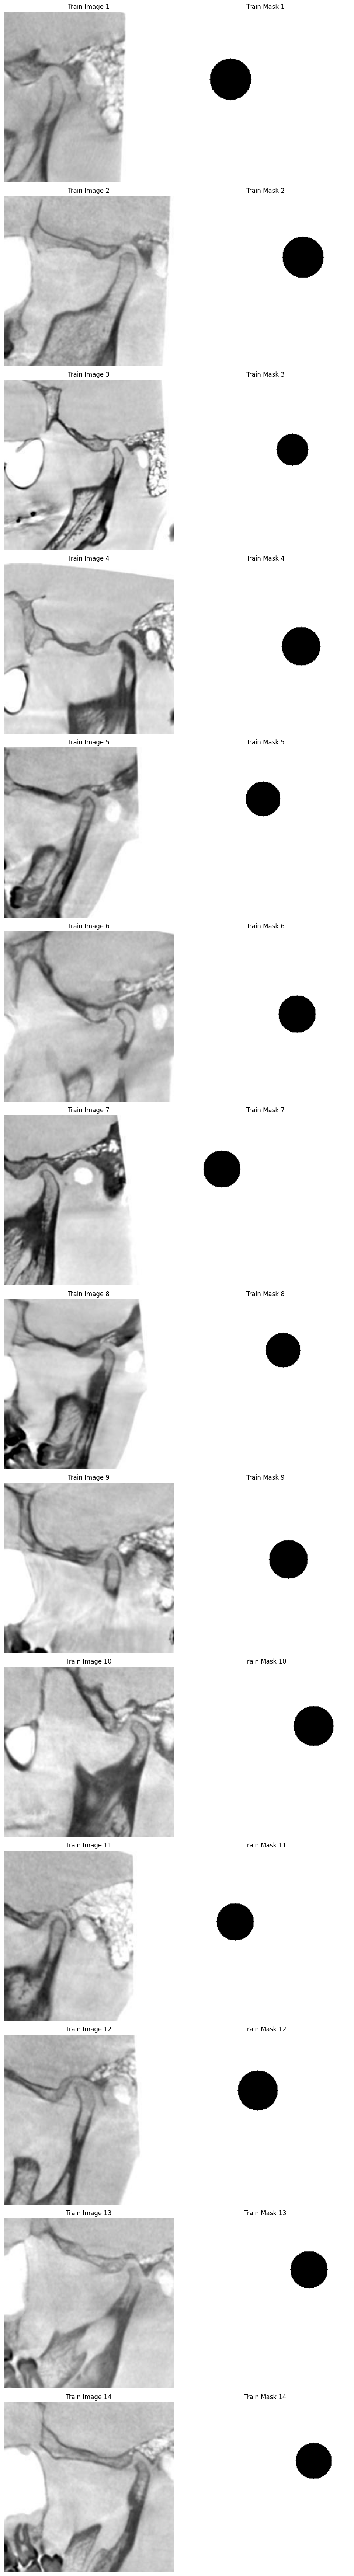

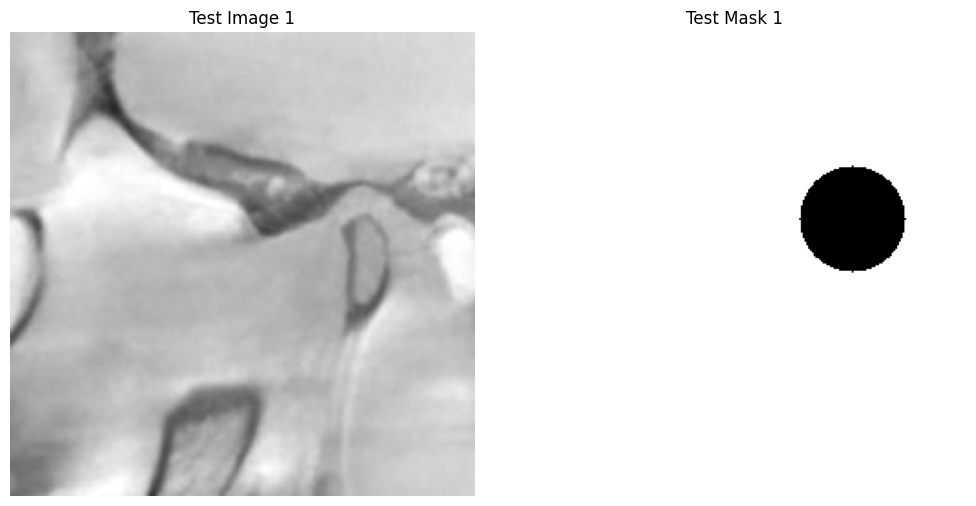

In [8]:
# Функция для отображения пар изображений и масок
def display_image_mask_pairs(images, masks, title='Train'):
    num_pairs = len(images)
    plt.figure(figsize=(10, num_pairs * 5))
    
    for i in range(num_pairs):
        plt.subplot(num_pairs, 2, i * 2 + 1)
        plt.title(f"{title} Image {i+1}")
        plt.imshow(images[i])
        plt.axis('off')

        plt.subplot(num_pairs, 2, i * 2 + 2)
        plt.title(f"{title} Mask {i+1}")
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Squeeze убирает лишние измерения
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Отображение пар изображений и масок для тренировочного набора
display_image_mask_pairs(train_images, train_masks, title='Train')

# Отображение пар изображений и масок для тестового набора
display_image_mask_pairs(test_images, test_masks, title='Test')


In [9]:
# %%time
# # если пишем %%time то приобучении доппредупреждение

# # Измененная модель U-Net с использованием Dice Loss и Dice Coefficient в качестве метрики
# model = models.unet_2d((None, None, 3), layers, n_labels=1,                       
#                        stack_num_down=2, stack_num_up=2,
#                        activation='ReLU', output_activation='Sigmoid',
#                        batch_norm=True, pool='max', unpool='nearest', name='u-net')

# # Компиляция модели с Dice Loss
# model.compile(optimizer=RMSprop(), loss=dice_loss, metrics=[dice_coefficient])

# # Добавление callbacks
# callbacks = [
#     EarlyStopping(patience=25, verbose=1),
#     ModelCheckpoint('model-best.h5', verbose=1, save_best_only=True)
# ]

# # Обучение модели с callbacks и сохранение истории обучения
# history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks)

# # Загрузка лучшей модели и тестирование
# model.load_weights('model-best.h5')
# test_loss, test_dice_coefficient = model.evaluate(test_images, test_masks)
# print(f"Dice Coefficient на тестовых данных: {test_dice_coefficient}")

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Обучение')
# plt.plot(history.history['val_loss'], label='Валидация')
# plt.title('График потерь')
# plt.xlabel('Эпоха')
# plt.ylabel('Потеря')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['dice_coefficient'], label='Обучение')
# plt.plot(history.history['val_dice_coefficient'], label='Валидация')
# plt.title('График Dice Coefficient')
# plt.xlabel('Эпоха')
# plt.ylabel('Dice Coefficient')
# plt.legend()

# plt.tight_layout()
# plt.show()

## обучение

Epoch 1/185
Cause: Unable to locate the source code of <function dice_loss at 0x000001D9D5102F20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function dice_loss at 0x000001D9D5102F20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the 

D:\installed\anaconda3\envs\notebook\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.1814 - dice_coefficient: 0.8186
Epoch 2: val_loss did not improve from 0.33455
3/3 [==============================] - 5s 2s/step - loss: 0.1814 - dice_coefficient: 0.8186 - val_loss: 0.3357 - val_dice_coefficient: 0.6643
Epoch 3/185
3/3 [==============================] - ETA: 0s - loss: 0.1399 - dice_coefficient: 0.8601
Epoch 3: val_loss improved from 0.33455 to 0.32685, saving model to model-best.h5
3/3 [==============================] - 5s 2s/step - loss: 0.1399 - dice_coefficient: 0.8601 - val_loss: 0.3269 - val_dice_coefficient: 0.6731
Epoch 4/185
3/3 [==============================] - ETA: 0s - loss: 0.1272 - dice_coefficient: 0.8728
Epoch 4: val_loss improved from 0.32685 to 0.31802, saving model to model-best.h5
3/3 [==============================] - 5s 2s/step - loss: 0.1272 - dice_coefficient: 0.8728 - val_loss: 0.3180 - val_dice_coefficient: 0.6820
Epoch 5/185
3/3 [==============================] - ETA: 0s - loss: 0.111

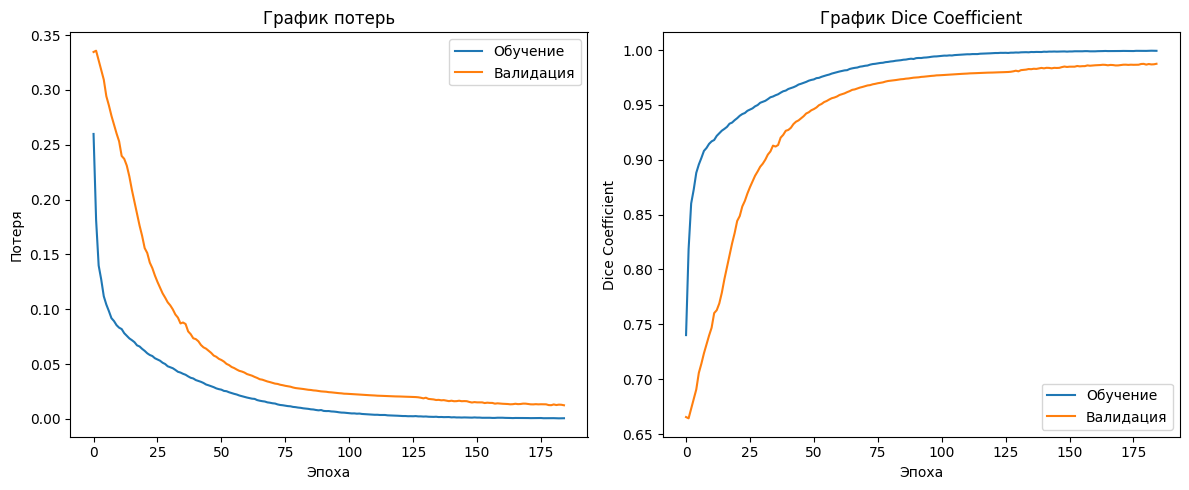

CPU times: total: 1h 28min 23s
Wall time: 16min 31s


In [10]:
%%time

# Функция для вычисления Dice Coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Функция потерь Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Измененная модель U-Net с использованием Dice Loss и Dice Coefficient в качестве метрики
model = models.unet_2d((None, None, 3), layers, n_labels=1,                       
                       stack_num_down=2, stack_num_up=2,
                       activation='ReLU', output_activation='Sigmoid',
                       batch_norm=True, pool='max', unpool='nearest', name='u-net')

# Компиляция модели с Dice Loss
model.compile(optimizer=RMSprop(), loss=dice_loss, metrics=[dice_coefficient])

# Добавление callbacks
callbacks = [
    EarlyStopping(patience=25, verbose=1),
    ModelCheckpoint('model-best.h5', verbose=1, save_best_only=True)
]

# Обучение модели с callbacks и сохранение истории обучения
history = model.fit(train_images, train_masks, batch_size=batch_size, epochs=epochs, 
                    validation_split=0.1, callbacks=callbacks)

# Загрузка лучшей модели и сохранение всей модели
model.load_weights('model-best.h5')  # Загрузка лучших весов
model.save('full_model_best.h5')  # Сохранение всей модели

# Тестирование модели
test_loss, test_dice_coefficient = model.evaluate(test_images, test_masks)
print(f"Dice Coefficient на тестовых данных: {test_dice_coefficient}")

# Построение графиков потерь и Dice Coefficient
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'], label='Обучение')
plt.plot(history.history['val_dice_coefficient'], label='Валидация')
plt.title('График Dice Coefficient')
plt.xlabel('Эпоха')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Для дообучения модели в будущем -загрузим модель с пользовательскими функциями:
model = load_model('full_model_best.h5', custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})

# model.fit(new_train_images, new_train_masks, batch_size=new_batch_size, epochs=new_epochs, validation_split=0.1, callbacks=new_callbacks)

## предсказание

1/1 [==============================] - 1s 531ms/step


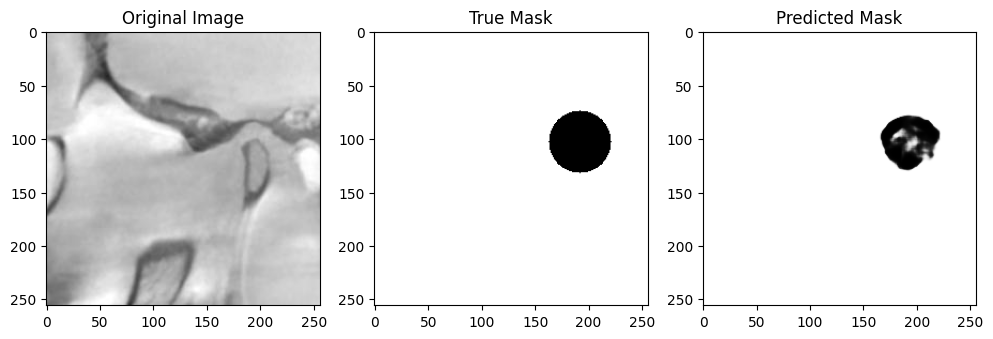

In [12]:
# Выбор случайного тестового изображения
random_index = np.random.randint(0, len(test_images))
test_image = test_images[random_index]
test_mask = test_masks[random_index]

# Предсказание сегментированной маски
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Подготовка изображения для отображения
plt.figure(figsize=(12, 6))

# Отображение оригинального изображения
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_image)

# Отображение истинной маски
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(test_mask, cmap='gray')

# Отображение предсказанной маски
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')  # squeeze для удаления лишних измерений

plt.show()

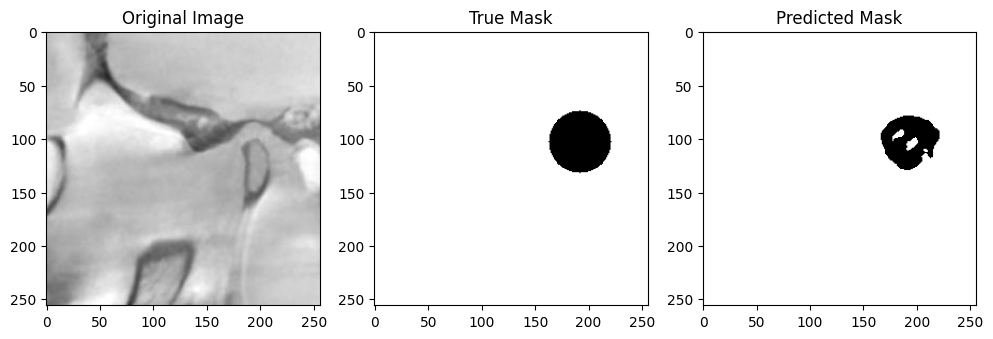

In [13]:
threshold = 0.5  # порог подобрать 
binary_mask = (predicted_mask > threshold).astype(np.uint8)  # Получаем двоичную маску


# Подготовка изображения для отображения
plt.figure(figsize=(12, 6))

# Отображение оригинального изображения
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_image)

# Отображение истинной маски
plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(test_mask, cmap='gray')

# Отображение предсказанной маски
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(binary_mask.squeeze(), cmap='gray')  # squeeze для удаления лишних измерений

plt.show()

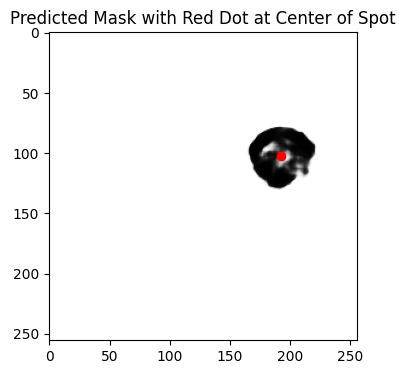

In [14]:
# Finding the center of the black spot
center = center_of_mass(binary_mask == 0)
# Creating a plot to display the mask with a red dot at the center of the black spot
plt.figure(figsize=(4, 4))
plt.imshow(predicted_mask, cmap='gray')
plt.plot(center[1], center[0], 'ro')  # Center of mass returns (row, column), plot requires (x, y)
plt.title("Predicted Mask with Red Dot at Center of Spot")
plt.show()

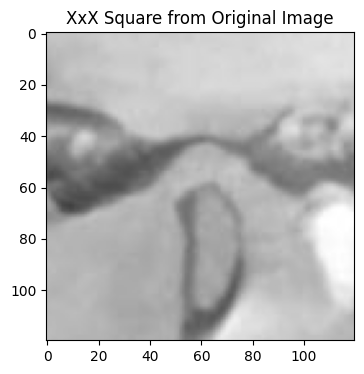

In [15]:
# Coordinates of the center (red dot) from the previous operation
center_x, center_y = int(center[1]), int(center[0])

# Calculate the coordinates for the XxX square
half_size = int(suare_side_pix / 2)  # Half the size of the square
start_x = max(center_x - half_size, 0)
end_x = min(center_x + half_size, test_image.shape[1])
start_y = max(center_y - half_size, 0)
end_y = min(center_y + half_size, test_image.shape[0])

# Extracting the XxX square
square_XxX = test_image[start_y:end_y, start_x:end_x]

# Displaying the extracted square
plt.figure(figsize=(4, 4))
plt.imshow(square_XxX, cmap='gray')
plt.title("XxX Square from Original Image")
plt.show()

## тестовый прогон

In [33]:
# Путь к директории с фотографиями
foto_directory_test = r"E:\gnat\gnat_set_center\test"
suare_side_pix = 90 # итоговое изображение для проставления точек измерения

# ПРЕДОБРАБОТКА
# инвертирование + контраст + частичная обрезка

for filename in os.listdir(foto_directory_test): # Перебор всех файлов в директории
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Проверка, что файл является изображением
        img_path = os.path.join(foto_directory_test, filename)
        with Image.open(img_path) as img:
            # Проверка, нужно ли обрезать изображение
            if img.size[0] > target_width or img.size[1] > target_height:
                # Обрезка по горизонтали
                total_crop_width = img.size[0] - target_width
#                 left_crop = total_crop_width * 0.80
#                 right_crop = total_crop_width * 0.20
                left_crop = total_crop_width * 0.95
                right_crop = total_crop_width * 0.05
                left = left_crop
                right = img.size[0] - right_crop

                # Обрезка по вертикали
                total_crop_height = img.size[1] - target_height
                top_crop = total_crop_height * 0.5
                bottom_crop = total_crop_height * 0.5
                top = top_crop
                bottom = img.size[1] - bottom_crop

                # Обрезка изображения
                img = img.crop((left, top, right, bottom))
                          
            # БЕЗ ОБРАБОТКИ    
            # 1 Инвертирование цветов
            img_inverted = img
            # 2 Увеличение контрастности
            enhancer = ImageEnhance.Contrast(img_inverted)           
            img_contrasted = enhancer.enhance(1.0)  # Увеличиваем контраст на %            
                      
#             # ОБРАБОТАТЬ
#             img_inverted = ImageOps.invert(img)
#             enhancer = ImageEnhance.Contrast(img_inverted)
#             img_contrasted = enhancer.enhance(2.0)  # Увеличиваем контраст на %
                                  
            # 3 Изменение размера до new_width x new_height
            img_resized = img_contrasted.resize((new_width, new_height))
            
            # Сохранение обработанного изображения, заменяя оригинал
            img_resized.save(img_path)

In [34]:
# ЗАГРУЗКА СНИМКА

def load_images(directory):
    images = []
    filenames = []  # Добавляем список для хранения имен файлов

    for file in sorted(os.listdir(directory)): # Перебор всех файлов в директории
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, file)
            img = load_img(img_path, color_mode='rgb')
            img = img_to_array(img)
            images.append(img)
            filenames.append(file)

#             # Сохранение изображения с новым названием
#             new_img = array_to_img(img)  # Конвертация обратно в изображение PIL
#             new_filename = file.rsplit('.', 1)[0] + '_2.' + file.rsplit('.', 1)[1]
#             new_img_path = os.path.join(directory, new_filename)
#             new_img.save(new_img_path)
    return np.array(images), filenames

images_testing, filenames = load_images(foto_directory_test)
images_testing = images_testing.astype('float32') / 255 # Нормализация изображений
test_image = images_testing[0]

1/1 [==============================] - 0s 472ms/step


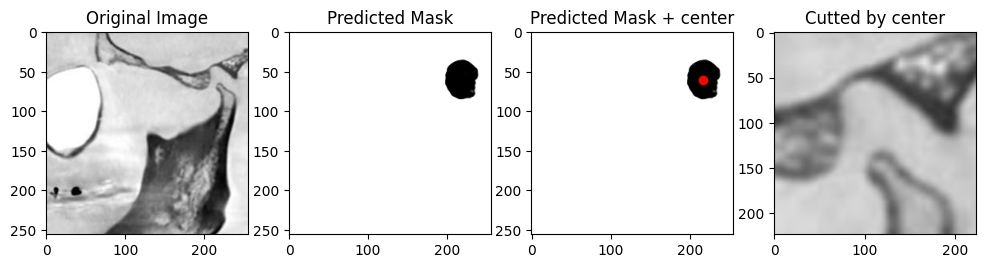

In [35]:
# СЕГМЕНТ + ЦЕНТР + обрезка

# Предсказание сегментированной маски
# Для дообучения модели в будущем -загрузим модель с пользовательскими функциями:
model = load_model('full_model_best.h5', custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})
# model.fit(new_train_images, new_train_masks, batch_size=new_batch_size, epochs=new_epochs, validation_split=0.1, callbacks=new_callbacks)
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]
threshold = 0.5  # порог подобрать 
binary_mask = (predicted_mask > threshold).astype(np.uint8)  # Получаем двоичную маску

# Подготовка изображения для отображения
plt.figure(figsize=(12, 6))

# (1) Отображение оригинального изображения
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(test_image)

# (2) Отображение предсказанной маски
plt.subplot(1, 4, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')  # squeeze для удаления лишних измерений

# (3) ЦЕНТР
center = center_of_mass(binary_mask == 0)
plt.subplot(1, 4, 3)
plt.title("Predicted Mask + center")
plt.imshow(predicted_mask, cmap='gray')
plt.plot(center[1], center[0], 'ro')  # Center of mass returns (row, column), plot requires (x, y)

# (4) вырезанный участок
center_x, center_y = int(center[1]), int(center[0])
# вычислим координаты участка по центру
half_size = 30  # Half the size of the square
start_x = max(center_x - half_size, 0)
end_x = min(center_x + half_size, test_image.shape[1])
start_y = max(center_y - half_size, 0)
end_y = min(center_y + half_size, test_image.shape[0])
cutted_bycenter = test_image[start_y:end_y, start_x:end_x] # обрезка участка

cutted_bycenter = cv2.resize(cutted_bycenter, (224, 224))
# cutted_bycenter = cv2.bitwise_not(cutted_bycenter) # инверт

plt.subplot(1, 4, 4)
plt.title("Cutted by center")
plt.imshow(cutted_bycenter, cmap='gray')

plt.show()

In [39]:
# СОХРАНИТЬ СНИМОК  224x224 в файл, добавив _cut_224x224

file = filenames[0]
cutted_bycenter_img = array_to_img(cutted_bycenter)  # Конвертация обратно в изображение PIL
new_filename = file.rsplit('.', 1)[0] + '_cut_224x224.' + file.rsplit('.', 1)[1]
new_img_path = os.path.join(foto_directory_test, new_filename)
cutted_bycenter_img.save(new_img_path)